# RB1 and TP53


Finding how many RB1 mutations also have a TP53 mutation

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
#sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
#import cis_functions as f

import cptac
import cptac.utils as u

In [2]:
def add_significance_col(results_df, num_comparisons):
    "bonferroni multiple hypothesis"""
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    pval = results_df['P_Value']
    if float(pval[0]) <= bonferroni_cutoff:
        results_df['Significant'] = True
    else: 
        results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


In [3]:
# note: pass reduced omics # CHECK would include non coding, but none in fm genes

def format_mutated_wt_comparison(reduced_omics_df):
    # Step 2 - Create binary column 
    reduced_omics_df['binary_mutations'] = np.where(
                reduced_omics_df[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = reduced_omics_df[reduced_omics_df.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    mut_status = tumors.drop(columns_to_drop, axis = 1)

    return mut_status

In [4]:
def get_missense_truncation_comparison(cancer_object, reduced_omics_df):
    #get omics data and tumors
    tumors = reduced_omics_df.loc[reduced_omics_df['Sample_Status'] == 'Tumor'] #drop Normal samples


    somatic_mutations = cancer_object.get_somatic_mutation().reset_index()

    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'Truncation', 
            'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
            'stopgain': 'Truncation', 'stoploss': 'Truncation', 'nonsynonymous SNV': 'Missense',
            'nonframeshift insertion': 'Missense','nonframeshift deletion': 'Missense', 
            'nonframeshift substitution': 'Missense'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'Missense', 'In_Frame_Ins': 'Missense',
            'Missense_Mutation': 'Missense', 'Frame_Shift_Del': 'Truncation','Nonsense_Mutation': 'Truncation', 
            'Splice_Site': 'Truncation', 'Frame_Shift_Ins': 'Truncation','Nonstop_Mutation':'Truncation'}

    mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
    mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Missense']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Truncation']

    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = list(miss['Sample_ID'].unique())
    trunc_unique_samples = list(trunc['Sample_ID'].unique())
    
    #check if there is only one type of mutation for the specific gene
    if miss_unique_samples == []:
        print('Only truncation type mutations found for', gene+'.', 
             'Not possible to compare missense with wildtype.')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = truncation_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics
    elif trunc_unique_samples == []:
        print('Only missence type mutations found for', gene+'.', 
             'Not possible to compare truncation with wildtype.')
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missense')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = missence_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics

    ### Step 2 - Create the binary column needed to do the comparison
    # Get mutation catagories with omics data
    missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
    missence_omics = missence_omics.assign(binary_mutations = 'Missense')
    truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
    truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
    binary_mut_omics = missence_omics.append(truncation_omics)

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

    return binary_mut_omics


In [5]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# used in pval_annotation
def get_pval_symbol(pval_df):
    if pval_df.iloc[0:,2].bool() == True:
        pval_symbol = '*'
    else:
        pval_symbol = 'ns'
    return pval_symbol

def pval_annotation(pval_df, plotted_df):
    # pval symbol
    num_pvals = len(pval_df)
    omics_col = plotted_df.columns[0]
    

    # annotation for Mutated and Wiltype
    if num_pvals == 1:
        mut_pval = pval_df.loc[pval_df.index == "Mutated/Wildtype"]
        mut_pval_symbol = get_pval_symbol(pval_df)
        
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    # annotation for Missense, Truncation and Wildtype
    elif num_pvals == 2:
        # Missense
        miss_pval = pval_df.loc[pval_df.index == "Missense/Wildtype"]
        miss_pval_symbol = get_pval_symbol(miss_pval)
    
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
        
        # Truncation 
        trunc_pval = pval_df.loc[pval_df.index == "Truncation/Wildtype"]
        trunc_pval_symbol = get_pval_symbol(trunc_pval)
        
        x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
        y2, h2 = plotted_df[omics_col].max() + .15, .05     
        plt.plot([x3, x3, x4, x4], #draw horizontal line
                 [y2, y2+h2, y2+h2, y2], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x3+x4)*.5, # half between x coord
                 y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


## Step 2: Find the mutation frequency of the gene of interest

In [14]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
desired_cutoff = 0.05
gene = 'TP53'

In [15]:
#FIX
#freq_mut = u.get_frequently_mutated(brain, cutoff = desired_cutoff)
#freq_mut.loc[freq_mut['Gene'] == gene]

# Proteomics cis comparison

Proteomics: Mutated and Wildtype

In [18]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = "TP53", omics_df_name = 'proteomics', omics_genes = "TP53") # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt_TP53 = format_mutated_wt_comparison(prot_and_mutations)

#prot_mut_wt_TP53 = prot_mut_wt_TP53.loc[prot_mut_wt_TP53 ["binary_mutations"] == "Mutated"]
prot_mut_wt_TP53

Name,TP53_proteomics,binary_mutations
Sample_ID,,
S001,0.16900,Mutated
S002,0.14800,Mutated
S003,-0.09660,Wildtype
S004,2.81000,Mutated
S005,-0.08040,Wildtype
...,...,...
S100,-0.00922,Wildtype
S101,NaN,Wildtype
S102,NaN,Wildtype


In [19]:
brain2 = cptac.Gbm()
gene = "RB1"

# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain2.join_omics_to_mutations(
    mutations_genes = "RB1", omics_df_name = 'proteomics', omics_genes = "RB1") # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt_RB1 = format_mutated_wt_comparison(prot_and_mutations)
#prot_mut_wt_RB1 = prot_mut_wt_RB1.loc[prot_mut_wt_RB1 ["binary_mutations"] == "Mutated"]
prot_mut_wt_RB1


Name,RB1_proteomics,binary_mutations
Sample_ID,,
S001,-1.7700,Mutated
S002,-0.9180,Mutated
S003,0.2240,Wildtype
S004,-0.9840,Mutated
S005,0.2260,Wildtype
...,...,...
S100,-0.2190,Wildtype
S101,1.2300,Wildtype
S102,0.0235,Wildtype


RB1 only has 10 mutations total 8/10 also had a TP53 mutation 

Proteomics: Missense and Truncation compared to wildtype

In [20]:

#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["RB1"+'_proteomics']
prot_col = "RB1"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_wt_RB1, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,RB1_proteomics,2.568098e-08,True


In [21]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(brain, prot_and_mutations)
prot_wildtype = prot_mut_wt_RB1.loc[prot_mut_wt_RB1['binary_mutations'] == 'Wildtype'] # select all wildtype 
RB1_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = RB1_prot_miss_trunc_wildtype.loc[RB1_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

prot_results_miss_trunc = prot_results_trunc
prot_results_miss_trunc
RB1_prot_miss_trunc_wildtype



Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.
Doing t-test comparison for truncation and wildtype


Name,RB1_proteomics,binary_mutations
Sample_ID,,
S001,-1.7700,Truncation
S002,-0.9180,Truncation
S004,-0.9840,Truncation
S014,-1.2700,Truncation
S041,-0.8910,Truncation
...,...,...
S100,-0.2190,Wildtype
S101,1.2300,Wildtype
S102,0.0235,Wildtype


In [26]:
prot_mut_wt_RB1 = pd.merge(RB1_prot_miss_trunc_wildtype, prot_mut_wt_TP53, on = "Sample_ID")
Mut_RB1_TP53 = prot_mut_wt_RB1.rename(columns = {"binary_mutations_x":"RB1_mutation", "binary_mutations_y": "TP53_mutation"})
Mut_RB1_TP53

Name,RB1_proteomics,RB1_mutation,TP53_proteomics,TP53_mutation
Sample_ID,,,,
S001,-1.7700,Truncation,0.16900,Mutated
S002,-0.9180,Truncation,0.14800,Mutated
S004,-0.9840,Truncation,2.81000,Mutated
S014,-1.2700,Truncation,0.12100,Wildtype
S041,-0.8910,Truncation,0.92900,Mutated
...,...,...,...,...
S100,-0.2190,Wildtype,-0.00922,Wildtype
S101,1.2300,Wildtype,NaN,Wildtype
S102,0.0235,Wildtype,NaN,Wildtype


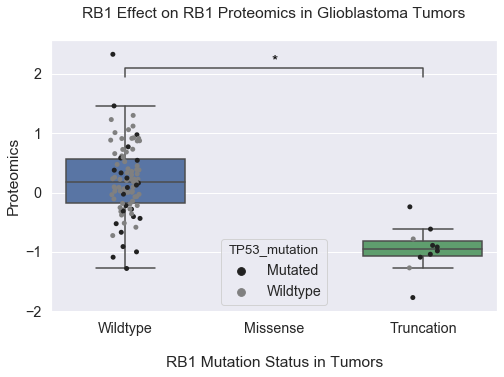

In [37]:
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = Mut_RB1_TP53, x = 'RB1_mutation',
                          y = prot_col, order = ['Wildtype', 'Missense', 'Truncation'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Proteomics in Glioblastoma Tumors\n")
cis_boxplot = sns.stripplot(data= Mut_RB1_TP53, x = 'RB1_mutation',
                            y = prot_col,jitter = True, color = ".5", hue = "TP53_mutation", order = ['Wildtype', 'Missense', 'Truncation'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Proteomics')
#cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# Missense
#miss_pval = prot_results_miss_trunc.loc[prot_results_miss_trunc.index == "Missense/Wildtype"]
#miss_pval_symbol = get_pval_symbol(miss_pval)
#format_pval_annotation(miss_pval_symbol, x1 = 0, x2 = 1, line_start = 1.65, line_height = 0.15)

# Truncation 
trunc_pval = prot_results_miss_trunc.loc[prot_results_miss_trunc.index == "Truncation/Wildtype"]
trunc_pval_symbol = get_pval_symbol(trunc_pval)
format_pval_annotation(trunc_pval_symbol, x1 = 0, x2 = 2, line_start = 1.95, line_height = 0.15)

plt.show()
plt.clf()
plt.close()